In [ ]:
import earthaccess   
import numpy as np  
import matplotlib.pyplot as plt  
import os
from netCDF4 import Dataset
import geopandas as gpd
import cmocean

#Authenticate
earthaccess.login()

#Searching for Cryosat2 Sea Ice Thickness Data for 2024
#Returns a list of DataGranule objects
search_results = earthaccess.search_data(
    short_name="RDEFT4",
    bounding_box=(-163.5, 66.4, -161.1, 67.1), #Contains Kotzebue Sound
    temporal=("2023-09-01", "2024-05-31"),
)

#Returns a list of downloaded files
raw_files = earthaccess.download(search_results[0:5], local_path='data/')

Granules found: 234
 Getting 5 granules, approx download size: 0.02 GB


QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
#Unpack netCDF files so that we can extract the features we want
data_list = []
for file in os.listdir('data/'):
    file_path = os.path.join('data', file)
    data_list.append(Dataset(file_path))
    print(data_list[0])

thickness_list = []
coords_list = []
for d in range(len(data_list)):
    thickness_list.append(data_list[d].variables['sea_ice_thickness'][:,:].flatten().T)
    coords_list_entry = (data_list[d].variables['lat'][:,:].flatten().T,
                  data_list[d].variables['lon'][:,:].flatten().T)
    coords_list.append(np.vstack(coords_list_entry).T)

ice_thickness = np.hstack(thickness_list)
coords = np.vstack(coords_list)

print(ice_thickness.shape)
print(coords.shape)

df_actual = gpd.GeoDataFrame({"thickness": ice_thickness, "geometry": gpd.points_from_xy(coords[:,1], coords[:,0])})
df_kobuk = df_actual.cx[-164:-161, 66:68]
print(df_kobuk)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Title: NASA GSFC CryoSat-2 sea ice thickness and ancillary data
    Abstract: This data set contains monthly averaged Arctic sea ice thickness estimates and ancillary data. The primary data set used in the production of these data come from the ESA CryoSat-2 satellite. Sea ice freeboard is determined from CryoSat-2 using the method described in the Reference section below. In brief, this method uses a physical model to determine the best fit to each CryoSat-2 waveform.The fitted waveform is used to determine the retracking correction and also allows determination of the surface roughness within the footprint. For sea ice floes, the dominant backscattering layer is taken to be from the sea ice surface and thus sea ice freeboard is here defined as the height of the ice layer above the local sea surface. The DTU10 MSS is subtracted from each elevation measurement and the elevations from leads and s

/Users/maddykovaleski/miniforge3/envs/math_env/lib/python3.8/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


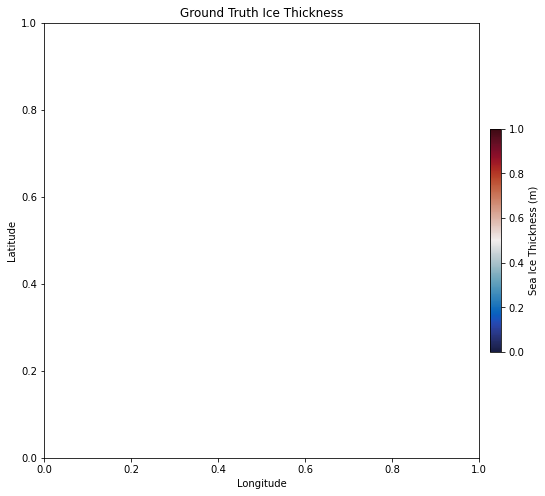

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

x_min, x_max = -164, -161
y_min, y_max = 66, 68
zoom_x = 0.9  
zoom_y = 0.8

x_range = (x_max - x_min) * (1 - zoom_x) / 2
y_range = (y_max - y_min) * (1 - zoom_y) / 2

# Plot
im1 = df_kobuk.plot(column="thickness", cmap=cmocean.cm.balance, markersize=10, alpha=0.7, legend=False, ax=ax)
ax.set_title("Ground Truth Ice Thickness")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_xlim(x_min + x_range, x_max - x_range)
#ax.set_ylim(y_min + y_range, y_max - y_range)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmocean.cm.balance)
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Sea Ice Thickness (m)")

plt.show()